1.Download the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2.Import required library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
%matplotlib inline

3.1 Read dataset

In [3]:
data=pd.read_csv("/content/drive/MyDrive/Assignment4_dataset/spam.csv", encoding="ISO-8859-1")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


3.2 Pre-processing

In [7]:
df=data.drop(data[["Unnamed: 2","Unnamed: 3","Unnamed: 4"]],axis=1)

In [8]:
df.rename(columns={"v1":"Target", "v2":"Text"}, inplace=True)
df

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Text(0, 0.5, 'Number of Data points')

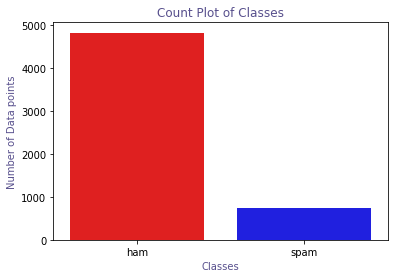

In [10]:
plt.figure(figsize=(6,4))
fg=sns.countplot(x=df["Target"], palette=["red", "blue"])
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
df["No_of_characters"]=df["Text"].apply(len)
df["No_of_words"]=df.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


In [13]:
df.head()

,Target,Text,No_of_characters,No_of_words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


<Figure size 1296x864 with 0 Axes>

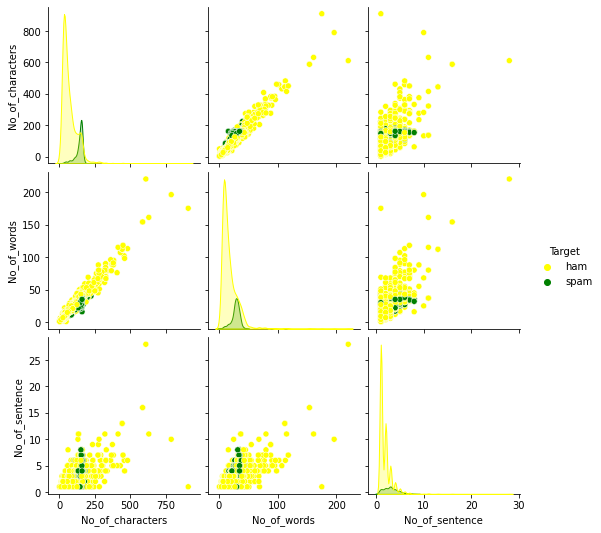

In [14]:
plt.figure(figsize=(18,12))
fg=sns.pairplot(data=df, hue="Target", palette=["yellow","green"])
plt.show(fg)

In [22]:
def Clean(Text):
  sms=re.sub('[^a-zA-Z]',' ',Text)
  sms=sms.lower()
  sms=sms.split()
  sms=' '.join(sms)
  return sms
df["Clean_Text"]=df["Text"].apply(Clean)  

In [23]:
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

In [24]:
nltk.download('stopwords')
def remove_stopwords(text):
  stop_words=set(stopwords.words("english"))
  filtered_text=[word for word in text if word not in stop_words]
  return filtered_text

df["Nostopwords_Text"]=df["Tokenize_Text"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [27]:
lemmatizer=WordNetLemmatizer()

def lemmatize_word(text):
  lemmas=[lemmatizer.lemmatize(word, pos='v')for word in text]
  return lemmas

df["Lemmatized_Text"]=df["Nostopwords_Text"].apply(lemmatize_word)

In [28]:
corpus=[]
for i in df["Lemmatized_Text"]:
  msg=' '.join([row for row in i])
  corpus.append(msg)

corpus[:5]  

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [29]:
df.tail()

,Target,Text,No_of_characters,No_of_words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopwords_Text,Lemmatized_Text
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,this is the nd time we have tried contact u u ...,"[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, u, pound, prize,...","[nd, time, try, contact, u, u, pound, prize, c..."
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,will b going to esplanade fr home,"[will, b, going, to, esplanade, fr, home]","[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,pity was in mood for that so any other suggest...,"[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,the guy did some bitching but i acted like i d...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, somethi..."
5571,ham,Rofl. Its true to its name,26,7,2,rofl its true to its name,"[rofl, its, true, to, its, name]","[rofl, true, name]","[rofl, true, name]"


4.Create Model

In [30]:
X=df.Clean_Text
Y=df.Target
le=LabelEncoder()
Y=le.fit_transform(Y)
Y=Y.reshape(-1,1)

In [31]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15)

In [32]:
max_words=1000
max_len=150
tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences=tok.texts_to_sequences(X_train)
sequences_matrix=pad_sequences(sequences,maxlen=max_len)

5.Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [33]:
def RNN():
  inputs=Input(name='inputs',shape=[max_len])
  layer=Embedding(max_words,50,input_length=max_len)(inputs)
  layer=LSTM(64)(layer)
  layer=Dense(256,name='FC1')(layer)
  layer=Activation('relu')(layer)
  layer=Dropout(0.5)(layer)
  layer=Dense(1,name='out_layer')(layer)
  layer=Activation('sigmoid')(layer)
  model=Model(inputs=inputs,outputs=layer)
  return model

6.Compile the Model

In [34]:
model=RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

7.Fit the model

In [35]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 12s 317ms/step - loss: 0.3236 - accuracy: 0.8762 - val_loss: 0.2205 - val_accuracy: 0.9789
Epoch 2/10
30/30 [==============================] - 9s 287ms/step - loss: 0.0925 - accuracy: 0.9778 - val_loss: 0.0569 - val_accuracy: 0.9831


8.Save The Model

In [36]:
model.save('sms_classifier.h5')

9.Test The Model

In [37]:
test_sequences=tok.texts_to_sequences(X_test)
test_sequences_matrix=pad_sequences(test_sequences,maxlen=max_len)

In [38]:
accr=model.evaluate(test_sequences_matrix,Y_test)


27/27 [==============================] - 1s 23ms/step - loss: 0.0504 - accuracy: 0.9868


In [39]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.050
 Accuracy: 0.987
